# EmoSense
# Understanding Group Emotions through Individual Facial Analysis


# Business Problem
Picture this: You're organizing a company retreat, a school assembly, or perhaps a community gathering. As the organizer, you're keen to ensure everyone is engaged and enjoying themselves. But how can you gauge the collective mood of the group? That's where this project comes in. The aim is to develop a system capable of analyzing group images to identify the emotions of the individuals within them. By employing deep learning models and algorithms, we aim to identify whether the group is demonstrating happiness, enthusiasm, apprehension, or any other emotional state.



Such a system holds immense potential for various applications. For businesses, it could provide valuable insights into employee satisfaction during team-building events or meetings. In educational settings, it could help educators assess student engagement during lectures or group activities. Even event organizers could leverage this tool to ensure attendees are having a positive experience. Ultimately, by decoding group emotions through visual data, we strive to enhance social dynamics and foster environments favorable to collective well-being and productivity.

# Existing Solution and Limitations
Understanding group emotions from group images is challenging because it involves identifying how each person in the group feels, which can be different for everyone. Traditional methods often treat the whole group as feeling the same way, missing the individual emotions. Also, analyzing group pictures accurately means needing to pick out emotions from both the whole group and each person's face, which can be hard because of different lighting and facial expressions. Plus, emotions can be subtle and vary based on the situation, making it tricky to get it right. Finally, doing this quickly and accurately is important for tasks like managing events or customer interactions.



# Proposed Solution
This project aims to redefine the way we perceive and interpret group emotions by implementing an approach that takes into account the individual emotions within a group. Instead of solely analyzing group images as a whole, our solution involves employing deep learning models to extract emotions of individuals given group images. We strive to create a comprehensive understanding of group emotions that captures the rich diversity of feelings present among group members.

# Instructions to run the code:<br>
Directories Required:<br>
annotations/images<br>
annotations/labels<br>
models<br>
face_path<br>
data<br>

Load all the models required in the models folder. I used the below models:<br>
yolov8n-face.pt for face detection<br>
Face_model.h5 for face emotion classification<br>
FSRCNN_x3.pb(lighter model) model for Super Resolution<br>
EDSR_x3.pb(heavier model) for Super Resolution<br>

For Validation, I have used the YOLO format after labeling using Label-Studio. Add all the validation images into annotations/images and corresponding labels into annotations/labels.<br>
Face_path is created to store temporary face data, which is used to pass for the DeepFace method.<br><br>

Run the following commands before running the code:<br>
pip install opencv-python torch torchvision ultralytics<br>
pip install deepface opencv-python<br>

There are two extract_image_data(image_path,model) methods, you can use either of the one based on the model you are using. Here, one methods is implemented based on Yolo face detection model and the other method is implemented based on Haar Cascade detection model.<br>
Similarly, there are two classify_emotions(faces) methods. You can use either one. One method uses the DeepFace method to classify emotions while the other uses a pre pre-trained model to classify emotions. By default, I'm using the DeepFace method.


Downloading the required modules

In [ ]:
!pip install opencv-python torch torchvision ultralytics
!pip install deepface opencv-python

Importing all the modules required

In [ ]:
import torch
from PIL import Image
import cv2
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
from deepface import DeepFace
from collections import Counter
import os
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
from shapely.geometry import box as shapely_box
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import tensorflow as tf

Given the model and the image path, predict the boundingboxes of the faces and also extract the faces using the bounding boxes

In [ ]:
# Yolo Model
def extract_image_data(image_path,model):
  """
  predicts the bounding boxes of the faces and also extracts the faces using the bounding boxes
  image_path is the image path
  model is the face detection model used
  """
  # read the image from the image path and get the results
  image = cv2.imread(image_path)
  image_results = model(image)

  # extract the bounding boxes obtained from the results
  predicted_bounding_boxes = []
  for result in image_results:
      for bounding_box in result.boxes:
          # Extracting bounding box coordinates
          bounding_box = bounding_box.xyxy[0].tolist()
          predicted_bounding_boxes.append(bounding_box)

  # extract faces from the bounding boxes obtained
  faces = []
  for bounding_box in predicted_bounding_boxes:
      xmin, ymin, xmax, ymax = map(int, bounding_box)
      face = image[ymin:ymax, xmin:xmax]
      faces.append(face)

  return faces, predicted_bounding_boxes

In [ ]:
# #HaarCascade
# def extract_image_data(image_path,model):
#   """
#   predicts the bounding boxes of the faces and also extracts the faces using the bounding boxes
#   image_path is the image path
#   model is the face detection model used
#   """
#   # read the image from the image path and get the results
#   image = cv2.imread(image_path)
#   grayscale_iamge = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#   # extract the bounding boxes obtained from the results
#   predicted_bounding_boxes = model.detectMultiScale(grayscale_iamge, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
#   faces = []
#   for bounding_box in predicted_bounding_boxes:
#       xmin, ymin, xmax, ymax = map(int, bounding_box)
#       face = image[ymin:ymin+ymax, xmin:xmin+xmax]
#       faces.append(face)
#   # faces = [image[y:y+h, x:x+w] for (x, y, w, h) in predicted_bounding_boxes]

#   return faces, predicted_bounding_boxes

Given the faces, use DeepFace library to extract the predict the emotions of the faces given as input

In [ ]:
# Using DeepFace
def classify_emotions(faces):
  """
  using DeepFace library predicts the emotions of the given faces
  facses is the list of faces whose emotions needs to be predicted
  """
  predicted_emotions = []
  for i, face in enumerate(faces):
    face_path = f'/content/face_path/face_{i}.jpg'
    cv2.imwrite(face_path, face)

    try:
      deepface_emotions_result = DeepFace.analyze(face_path, actions=['emotion'],enforce_detection=False)
      predicted_emotions.append(deepface_emotions_result[0]['dominant_emotion'])
    except Exception as e:
      print(f"Exception {e} caught while analyzing face {i}")
    finally:
      os.remove(face_path)
  return predicted_emotions

In [ ]:
# # Using pre trained model
# emotion_model = load_model('/content/models/face_model.h5')
# emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
# def classify_emotions(faces):
#   emotions = []
#   for face in faces:
#       gray_face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
#       resized_face = cv2.resize(gray_face, (48, 48))
#       reshaped_face = resized_face.reshape(1, 48, 48, 1)
#       reshaped_face = reshaped_face / 255.0

#       prediction = emotion_model.predict(reshaped_face)
#       emotion = emotion_labels[np.argmax(prediction)]
#       emotions.append(emotion)
#   return emotions

Given an image predicted face emotions, get the group emotion by majority voting

In [ ]:
def get_majority_vote(emotions):
  """
  given list of emotions, calculates the majority emotion
  emotions is the list of emotions values
  """
  emotion_count = Counter(emotions)
  if emotions:
    majority_emotion = emotion_count.most_common(1)[0][0]
    return majority_emotion
  else:
    return "Unknown"

Given bounding Box values and the image, it displays the faces present in the image

In [ ]:
def display_faces(bounding_boxes, image):
  """
  from the bounding boxes given, displays the faces present in the image
  bounding_boxes is the bounding_boxes for the given image
  image is the input image
  """
  faces = []
  for bounding_box in bounding_boxes:
    xmin, ymin, xmax, ymax = map(int, bounding_box)
    face = image[ymin:ymax, xmin:xmax]
    faces.append(face)
  for i, face in enumerate(faces):
    cv2_imshow(face)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# YOLO Face
Ultralytics YOLOv8 is a cutting-edge, state-of-the-art (SOTA) model that builds upon the success of previous YOLO versions and introduces new features and improvements to further boost performance and flexibility. YOLOv8 is designed to be fast, accurate, and easy to use, making it an excellent choice for a wide range of object detection and tracking, instance segmentation, image classification and pose estimation tasks.

Here, I have used yolov8n-face model to detect the faces in the image and and used cv2 library to read the images and process i.

cv2 librray is used to visualize the faces detected and the the detected facses is passed to classify emotions to extract individual face emotions using deepface.

In [ ]:
# Load the YOLOv8 Face model
model = YOLO('/content/models/yolov8n-face.pt')  # Ensure you have the YOLOv8 Face model
image_path = '/content/sample_data/0feb3d90a46b426998d98f5e02aefa00.jpg'
faces, predicted_bounding_boxes = extract_image_data(image_path,model)
for i, face in enumerate(faces):
  cv2_imshow(face)
  cv2.waitKey(0)
  cv2.destroyAllWindows()


0: 448x640 19 faces, 193.4ms
Speed: 5.8ms preprocess, 193.4ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


# Using HaarCascade Model
Haar classifiers were used in the first real-time face detector. A Haar cascade classifier, is a machine learning object detection program that identifies objects in an image and video.

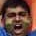

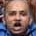

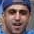

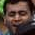

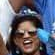

In [ ]:
# haarcascade_face_model = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# faces, predicted_bounding_boxes = extract_image_data(image_path,haarcascade_face_model)
# for i, face in enumerate(faces):
#   cv2_imshow(face)
#   cv2.waitKey(0)
#   cv2.destroyAllWindows()

In [ ]:
predicted_emotions = classify_emotions(faces)
# Anlyze the majority emotion of the group
group_emotion = get_majority_vote(predicted_emotions)
for i, emotion in enumerate(predicted_emotions):
    print(f'Face {i+1}: Emotion: {emotion}')

print(f'Majority Emotion of the Group is: {group_emotion}')

Face 1: Emotion: sad
Face 2: Emotion: fear
Face 3: Emotion: fear
Face 4: Emotion: fear
Face 5: Emotion: angry
Face 6: Emotion: happy
Face 7: Emotion: sad
Face 8: Emotion: sad
Face 9: Emotion: sad
Face 10: Emotion: happy
Face 11: Emotion: surprise
Face 12: Emotion: sad
Face 13: Emotion: angry
Face 14: Emotion: happy
Face 15: Emotion: angry
Face 16: Emotion: happy
Face 17: Emotion: fear
Face 18: Emotion: happy
Face 19: Emotion: sad
Majority Emotion of the Group is: sad


# Extract Label Data
The validation data is manually labelled using Label-Studio and the validation data is exported in the YOLO format(Popular TXT format is created for each image file. Each txt file contains annotations for the corresponding image file, that is object class, object coordinates, height & width.)
A map of the emotion classes is created based on the labelling and then the true bounding box and the true emotions for each of the faces of each image is extracted

In [ ]:
# Map class IDs to emotions
emotion_to_id_map = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'neutral',
    5: 'sad',
    6: 'surprise',

}

def get_true_bb_and_emotion(image_path,labels_path):
  """
  extract the true bounding box values and the treu emotions for the faces labelled in the given image
  image_path is the path iof the labelled image
  labels_path is the path of the label containing face labels data
  """
  image = cv2.imread(image_path)
  true_bounding_boxes = []
  true_emotions = []
  with open(labels_path, 'r') as label_file:
    for line in label_file:
      label_data = line.strip().split()
      emotions_id = int(label_data[0])
      x_center, y_center, width, height = map(float,label_data[1:])
      true_emotions.append(emotion_to_id_map[emotions_id])
      image_height, image_width = image.shape[:2]
      x_left = int((x_center - width /2) * image_width)
      y_left = int((y_center - height /2) * image_height)
      x_right = int((x_center + width /2) * image_width)
      y_right = int((y_center + height /2) * image_height)
      true_bounding_boxes.append([x_left, y_left, x_right, y_right])
      # bb.append([x_center, y_center, width, height])
  return true_bounding_boxes, true_emotions

Given two bounding boxes, get the ontersection over union between those two bounding boxes

In [ ]:
def get_intersection_over_union(true_bounding_box,predicted_bounding_box):
  """
  calculates the intersection over union between the true_bounding_box and the predicted_bounding_box
  """
  true_bounding_box = shapely_box(*true_bounding_box)
  predicted_bounding_box = shapely_box(*predicted_bounding_box)
  intersection = true_bounding_box.intersection(predicted_bounding_box).area
  union = true_bounding_box.union(predicted_bounding_box).area
  return intersection / union


Given the true and predicted bouding boxes and also the true and predicted emotions, for each true bounding box, find the best predicted_bounding box for it and also map the tru emotions with the respective predicted emotion

In [ ]:
def get_iou_scores_bb_predicted_emotions_map(true_bounding_boxes,predicted_bounding_boxes,true_emotions,predicted_emotions):
  """
  for each true bounding box, find the best predicted_bounding box for it and
  map the true emotions with the respective predicted emotion
  true_bounding_boxes is the labelled bounding boxes
  predicted_bounding_boxes is the predicted_bounding_boxes
  true_emotions is the labelled emotions values
  predicted_emotions is the emotions value predicted
  """
  all_intesection_over_union_scores = []
  mapped_predicted_emotions = []
  mapped_predicted_bounding_boxes = []
  considered_true_bounding_boxes = []
  considered_true_emotions = []
  i = 0
  for true_bounding_box in true_bounding_boxes:
    best_intersection_over_union = 0
    best_predicted_bounding_box = None
    for predicted_bounding_box in predicted_bounding_boxes:
      intesection_over_union = get_intersection_over_union(true_bounding_box,predicted_bounding_box)
      if intesection_over_union > best_intersection_over_union:
        best_intersection_over_union = intesection_over_union
        best_predicted_bounding_box = predicted_bounding_box
    if best_predicted_bounding_box:
      all_intesection_over_union_scores.append(best_intersection_over_union)
      mapped_predicted_bounding_boxes.append(best_predicted_bounding_box)
      predicted_bounding_box_index = predicted_bounding_boxes.index(best_predicted_bounding_box)
      mapped_predicted_emotions.append(predicted_emotions[predicted_bounding_box_index])
      considered_true_bounding_boxes.append(true_bounding_box)
      considered_true_emotions.append(true_emotions[i])
    i += 1
  return all_intesection_over_union_scores, mapped_predicted_emotions, mapped_predicted_bounding_boxes, considered_true_bounding_boxes, considered_true_emotions

One of the issues validating the data is that the predicted faces in a given image might not be in the order of the faces labeled. Hence, it is very important to make sure that we are comparing the right faces or else the analysis will be wrong.
To overcome this problem, for each labeled face bounding box, I find the best predicted bounding box and then I will map that corresponding face prediction values(bounding box and emotion) to the labeled face values.
In the below results, thw 1st result shows the order in which the labelled faces is considered. In the 2nd result, we see the order in which the model predicted faces are listed. Now, we need to make sure that somehow we map the faces accordingly. So, for each labelled face, we detect the best bounding box and map that face and emotions correspondingly. 3rd result displays the predicted faces order once the predicted faces are mapped with the labelled faces.


1.GIVEN IMAGE MANUALLY LABELED FACES ORDER



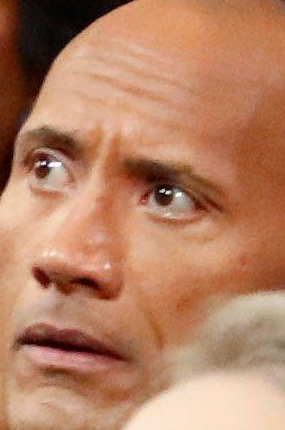

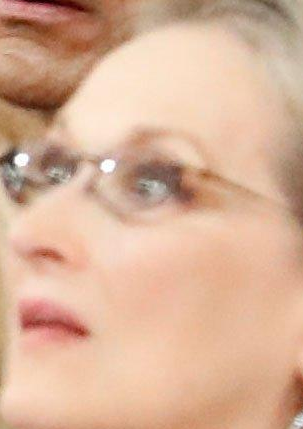

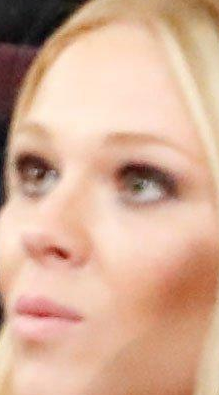

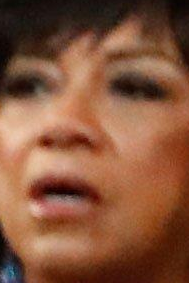


0: 640x640 4 faces, 227.5ms
Speed: 9.9ms preprocess, 227.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

2.GIVEN IMAGE PREDICTED FACES ORDER



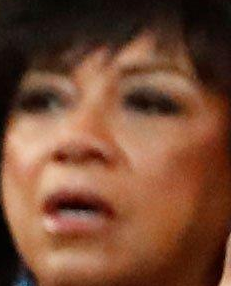

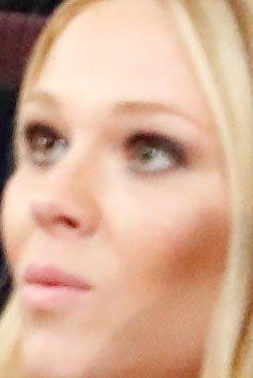

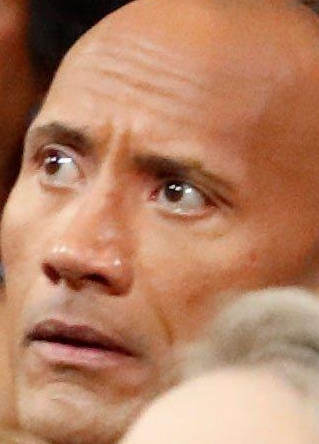

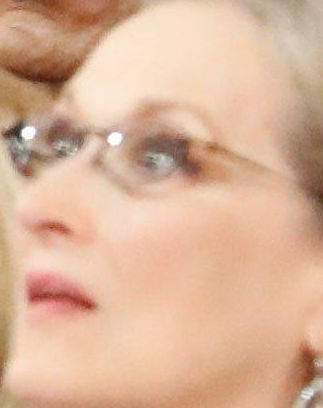


3.GIVEN IMAGE PREDICTED FACES MAPPED INORDER OF THE LABELED FACES ORDER



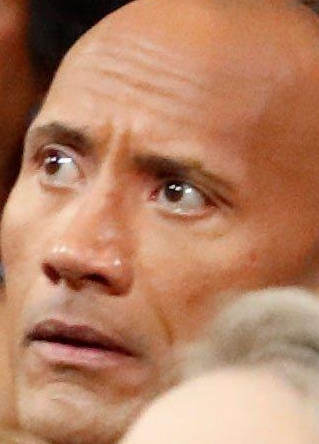

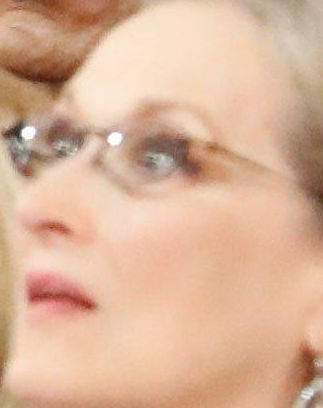

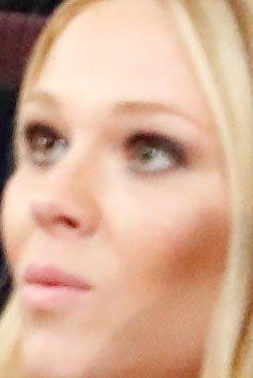

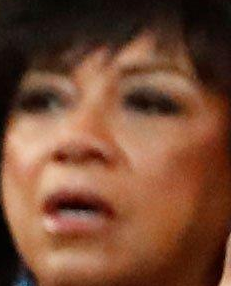

In [ ]:
# Load the YOLOv8 Face model
model = YOLO('/content/models/yolov8n-face.pt')  # Ensure you have the YOLOv8 Face model
# model = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the image
image_path = '/content/annotations/images/3e6247ac-ffb37d8da60b4aeeaedfc008ab4568cd.jpg'
label_path = '/content/annotations/labels/3e6247ac-ffb37d8da60b4aeeaedfc008ab4568cd.txt'
true_bounding_boxes, true_emotions = get_true_bb_and_emotion(image_path,label_path)
image = cv2.imread(image_path)
print("\n1.GIVEN IMAGE MANUALLY LABELED FACES ORDER\n")
display_faces(true_bounding_boxes, image)

faces, predicted_bounding_boxes = extract_image_data(image_path,model)
print("\n2.GIVEN IMAGE PREDICTED FACES ORDER\n")
display_faces(predicted_bounding_boxes, image)
predicted_emotions = classify_emotions(faces)

all_intesection_over_union_scores, mapped_predicted_emotions, mapped_predicted_bounding_boxes, considered_true_bounding_boxes, considered_true_emotions = get_iou_scores_bb_predicted_emotions_map(true_bounding_boxes,predicted_bounding_boxes,true_emotions,predicted_emotions)
print("\n3.GIVEN IMAGE PREDICTED FACES MAPPED INORDER OF THE LABELED FACES ORDER\n")
display_faces(mapped_predicted_bounding_boxes,image)

Difference in the number of labeled faces and predicted faces: The other issue arises when the number of faces labeled and the number of predicted faces for a given image is different. In this case, we clearly know that there is a mismatch in the number of faces labeled and predicted. But to map and analyze the accuracy accurately, for this case I have only considered the faces which were labeled and found a corresponding predicted bounding box. If for a labeled face, I don't find an intersection of the bounding box with any of the predicted bounding box, I'm not considering that face for evaluation. The reason is that, there will be no accurate face to use to compare and analyze it with. Similarly, I will ignore all the predicted faces which were not labeled.
For example: For the given image below, 13 faces were labeled and 13 faces were predicted. Now, out of those 13 faces labeled, I found corresponding bounding boxes for only 12 faces, then we only consider those 12 faces to be analyzed.



1.GIVEN IMAGE MANUALLY LABELED FACES ORDER



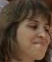

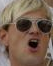

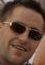

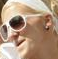

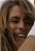

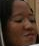

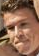

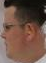

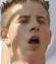

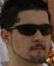

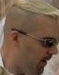

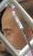


0: 448x640 13 faces, 170.3ms
Speed: 4.7ms preprocess, 170.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

2.GIVEN IMAGE PREDICTED FACES ORDER



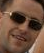

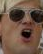

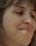

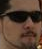

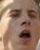

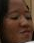

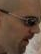

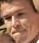

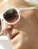


3.GIVEN IMAGE PREDICTED FACES MAPPED INORDER OF THE LABELED FACES ORDER



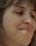

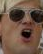

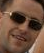

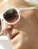

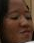

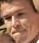

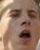

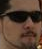

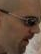

In [ ]:
# Load the YOLOv8 Face model
model = YOLO('/content/models/yolov8n-face.pt')  # Ensure you have the YOLOv8 Face model

# Load the image
image_path = '/content/annotations/images/a32d7c35-0_Parade_Parade_0_226.jpg'
label_path = '/content/annotations/labels/a32d7c35-0_Parade_Parade_0_226.txt'
true_bounding_boxes, true_emotions = get_true_bb_and_emotion(image_path,label_path)
image = cv2.imread(image_path)
print("\n1.GIVEN IMAGE MANUALLY LABELED FACES ORDER\n")
display_faces(true_bounding_boxes, image)

faces, predicted_bounding_boxes = extract_image_data(image_path,model)
print("\n2.GIVEN IMAGE PREDICTED FACES ORDER\n")
display_faces(predicted_bounding_boxes, image)
predicted_emotions = classify_emotions(faces)

all_intesection_over_union_scores, mapped_predicted_emotions, mapped_predicted_bounding_boxes, considered_true_bounding_boxes, considered_true_emotions = get_iou_scores_bb_predicted_emotions_map(true_bounding_boxes,predicted_bounding_boxes,true_emotions,predicted_emotions)
print("\n3.GIVEN IMAGE PREDICTED FACES MAPPED INORDER OF THE LABELED FACES ORDER\n")
display_faces(mapped_predicted_bounding_boxes,image)

# Evaluation
Given the labelled image directory and labelled directory, evaluate the iou scores, precision, recall, f1 score and also the accuracy.

In [ ]:
def evaluate_performance(image_dir, label_dir, model, super_resolution_model=None):
    iou_scores = []
    all_image_ture_emotions = []
    all_imamge_predicted_emotions = []
    true_group_emotions = []
    predicted_group_emotions = []
    total_latency = 0

    for image_name in os.listdir(image_dir):
        print(f'\nImage name = {image_name}')
        if not image_name.endswith(('.jpg', '.png')):
            continue

        image_path = os.path.join(image_dir, image_name)
        label_path = os.path.join(label_dir, image_name.replace('.jpg', '.txt').replace('.png', '.txt'))
        start_time = time.time()
        image = cv2.imread(image_path)
        if super_resolution_model:
          # print("super_resolution_model is used")
          image = super_resolution_model.upsample(image)

        true_bounding_boxes, true_emotions = get_true_bb_and_emotion(image_path,label_path)

        faces, predicted_bounding_boxes = extract_image_data(image_path,model)

        if faces:
            predicted_emotions = classify_emotions(faces)
        else:
            predicted_emotions = []

        latency = time.time() - start_time
        total_latency += latency

        all_intesection_over_union_scores, mapped_predicted_emotions, mapped_predicted_bounding_boxes, considered_true_bounding_boxes, considered_true_emotions = get_iou_scores_bb_predicted_emotions_map(true_bounding_boxes,predicted_bounding_boxes,true_emotions,predicted_emotions)

        true_group_emotion = get_majority_vote(considered_true_emotions)
        predicted_group_emotion = get_majority_vote(mapped_predicted_emotions)

        true_group_emotions.append(true_group_emotion)
        predicted_group_emotions.append(predicted_group_emotion)

        all_image_ture_emotions.extend(considered_true_emotions)
        all_imamge_predicted_emotions.extend(mapped_predicted_emotions)
        iou_scores.extend(all_intesection_over_union_scores)

    # Calculate metrics
    iou_mean = sum(iou_scores) / len(iou_scores)
    precision, recall, f1, _ = precision_recall_fscore_support(all_image_ture_emotions, all_imamge_predicted_emotions, average='weighted')
    accuracy = accuracy_score(all_image_ture_emotions, all_imamge_predicted_emotions)
    average_latency = total_latency / len(os.listdir(image_dir))

    return iou_mean, accuracy, precision, recall, f1, average_latency, iou_scores,all_image_ture_emotions,all_imamge_predicted_emotions,true_group_emotions,predicted_group_emotions

In [ ]:
# Paths to your dataset
image_dir = '/content/annotations/images'
label_dir = '/content/annotations/labels'
model = YOLO('/content/models/yolov8n-face.pt')
# model = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Evaluate performance
iou_mean, accuracy, precision, recall, f1, avg_latency, iou_scores,all_image_ture_emotions,all_image_predicted_emotions,true_group_emotions,predicted_group_emotions  = evaluate_performance(image_dir, label_dir, model)

print(f"IoU Mean: {iou_mean:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Average Latency: {avg_latency:.4f} seconds")


Image name = b0d327a3-35_Basketball_playingbasketball_35_867.jpg

0: 512x640 1 face, 219.7ms
Speed: 6.4ms preprocess, 219.7ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

Image name = 21363710-54_Rescue_rescuepeople_54_759.jpg

0: 448x640 4 faces, 160.9ms
Speed: 5.1ms preprocess, 160.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

Image name = 9a1f91c5-12_Group_Group_12_Group_Group_12_124.jpg

0: 544x640 9 faces, 193.2ms
Speed: 5.9ms preprocess, 193.2ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

Image name = 2a2770d7-0d461deffe324016ab2254c95d1a022c.jpg

0: 640x448 2 faces, 156.1ms
Speed: 8.9ms preprocess, 156.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

Image name = 61a2fd67-0c2d82c43e344a179c4986b6d254d9a0.jpg

0: 448x640 9 faces, 154.5ms
Speed: 4.7ms preprocess, 154.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

Image name = af6d90b6-35_Basketball_basketballgame_ball_35

# Visualization of the evaluation results
1. Histogram of the Iou Scores

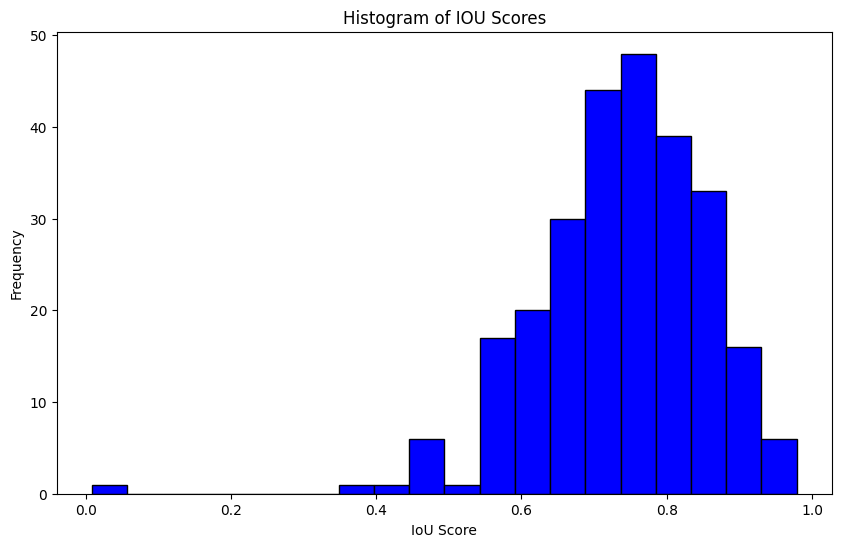

In [ ]:
# Plot Histogram of the intersection over union scores
plt.figure(figsize=(10, 6))
plt.hist(iou_scores, bins=20, color='blue', edgecolor='black')
plt.title('Histogram of IOU Scores')
plt.xlabel('IoU Score')
plt.ylabel('Frequency')
plt.show()

2. Confusion Matrix of Emotions

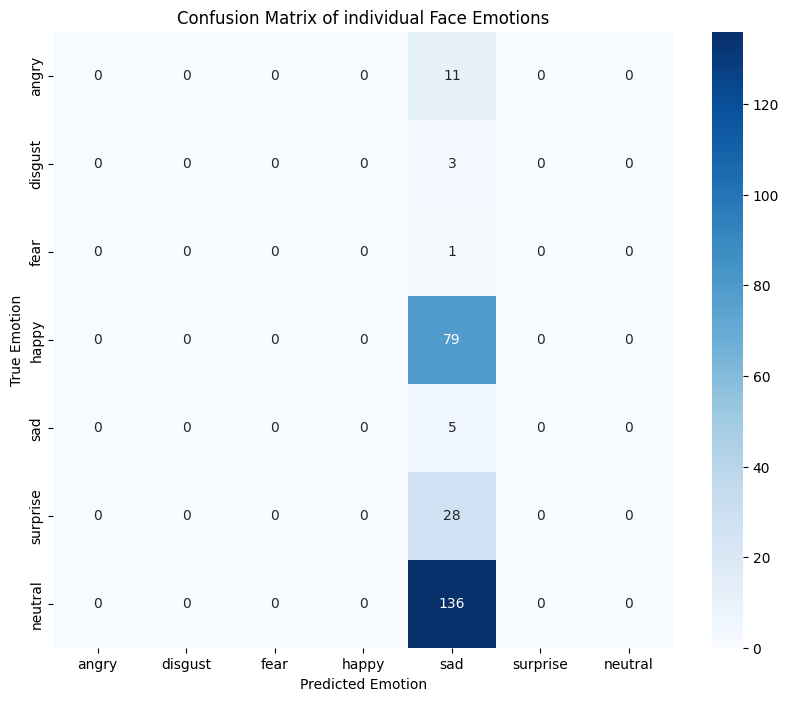

In [ ]:
import seaborn as sns
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
emotions_confusion_matrix = confusion_matrix(all_image_ture_emotions, all_image_predicted_emotions, labels=emotion_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(emotions_confusion_matrix, annot=True, fmt='d', xticklabels=emotion_labels, yticklabels=emotion_labels, cmap='Blues')
plt.title('Confusion Matrix of individual Face Emotions')
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.show()

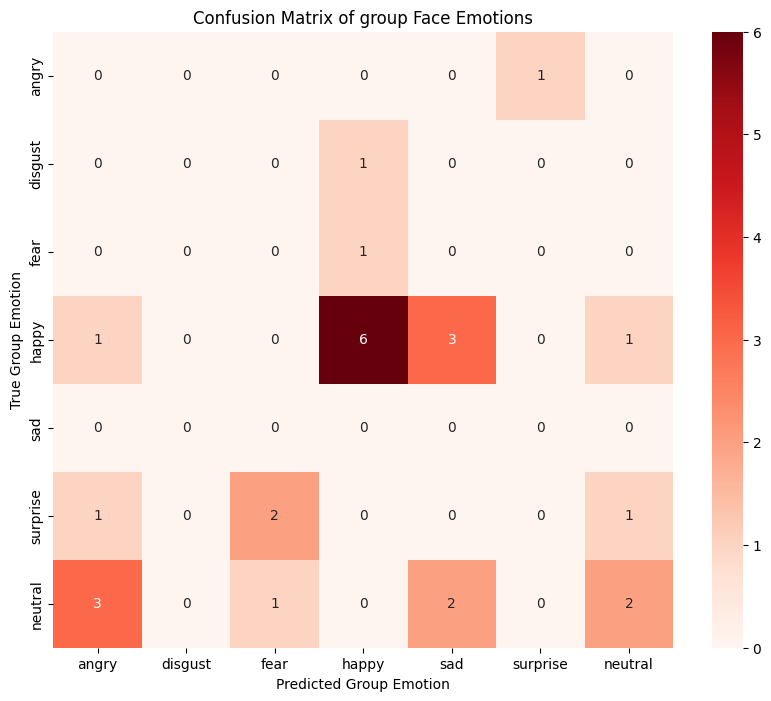

In [ ]:
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
group_emotions_confusion_matrix = confusion_matrix(true_group_emotions, predicted_group_emotions, labels=emotion_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(group_emotions_confusion_matrix, annot=True, fmt='d', xticklabels=emotion_labels, yticklabels=emotion_labels, cmap='Reds')
plt.title('Confusion Matrix of group Face Emotions')
plt.xlabel('Predicted Group Emotion')
plt.ylabel('True Group Emotion')
plt.show()

# Using Super Resolution to enhance image quality

In [ ]:
# Paths to your dataset
image_dir = '/content/annotations/images'
label_dir = '/content/annotations/labels'
model = YOLO('/content/models/yolov8n-face.pt')
super_resulution_model = cv2.dnn_superres.DnnSuperResImpl_create()
super_resulution_model.readModel("/content/models/FSRCNN_x3.pb")
super_resulution_model.setModel("fsrcnn", 3)

# model = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Evaluate performance
iou_mean, accuracy, precision, recall, f1, avg_latency, iou_scores,all_image_ture_emotions,all_image_predicted_emotions,true_group_emotions,predicted_group_emotions  = evaluate_performance(image_dir, label_dir, model,super_resulution_model)

print(f"IoU Mean: {iou_mean:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Average Latency: {avg_latency:.4f} seconds")


Image name = b0d327a3-35_Basketball_playingbasketball_35_867.jpg
super_resolution_model is used

0: 512x640 1 face, 427.9ms
Speed: 7.6ms preprocess, 427.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

Image name = 21363710-54_Rescue_rescuepeople_54_759.jpg
super_resolution_model is used

0: 448x640 4 faces, 179.0ms
Speed: 4.7ms preprocess, 179.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

Image name = 9a1f91c5-12_Group_Group_12_Group_Group_12_124.jpg
super_resolution_model is used

0: 544x640 9 faces, 212.5ms
Speed: 5.2ms preprocess, 212.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

Image name = 2a2770d7-0d461deffe324016ab2254c95d1a022c.jpg
super_resolution_model is used

0: 640x448 2 faces, 184.5ms
Speed: 5.8ms preprocess, 184.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)

Image name = 61a2fd67-0c2d82c43e344a179c4986b6d254d9a0.jpg
super_resolution_model is used

0: 448x640 9 faces, 255.4ms
Sp